Arbitrary N x N optical signal processor 

In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy

# add angler to path (not necessary if pip installed)
import sys
sys.path.append("..")

# import the main simulation and optimization classes
from angler import Simulation, Optimization

# import some structure generators
from angler.structures import three_port, two_port, N_port, N_IO_port

%load_ext autoreload
%autoreload 2
%matplotlib inline

Define simulation constants ==> L0 is default 1 micron

In [2]:
lambda0 = 1.55e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.05                  # grid size (L0)
NPML = [20, 20]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1e-3          # mW? amplitude of modal source (make around 1 for nonlinear effects)

In [3]:
# define material constants
n_index = 2.8              # refractive index
eps_m = n_index**2          # relative permittivity

Inputs = AE features MNIST, Outputs = MNIST classes 

In [4]:
# geometric parameters for a 1 -> 2 port device
L = 20     # length of box (L0) = micron 
N = 10         # Num output ports 
H = 20    # height of box (L0)
w = .5        # width of waveguides (L0)
d = H/10     # distance between waveguides (L0)
l = 5         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Definition of Simulation Object 

Computed a domain with 640 grids in x and 560 grids in y
The simulation has 30 grids per free space wavelength


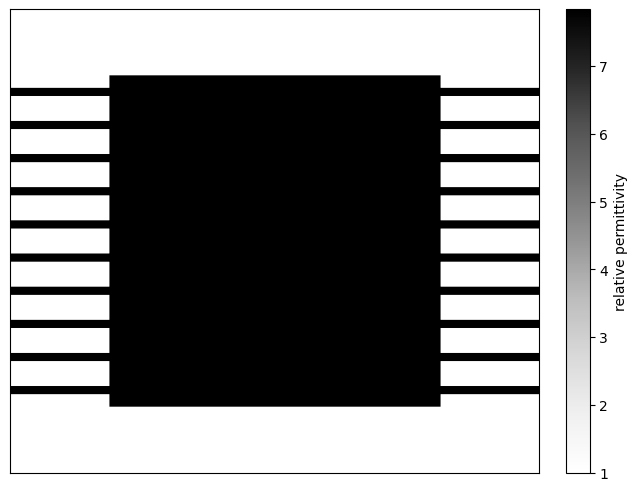

In [5]:
# define permittivity of three port system
eps_r, design_region = N_IO_port(N, L, H, w, d, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

# make a new simulation object
simulation = Simulation(omega, eps_r, dl, NPML, pol)

print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))

# plot the permittivity distribution
simulation.plt_eps(outline=False)
plt.show()

Sample input source 

In [6]:
# i = 9 # Waveguide num (start at 0)
# y_i =  # Waveguide y-pos
src_pos = []
for i in range(N):
    center = [NPML[0]+int(l/2/dl), ny-((float(i)-float(N-1)/2.0)*d/dl + w)]
    # set the input waveguide modal source
    simulation.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=center, width=int(H/13/dl), scale=source_amp)
    src_pos.append(center)
srcs = simulation.setup_modes()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Add modal profiles for auto-diff

In [14]:

# # make a new simulation to get the modal profile of the top output port
# top = Simulation(omega, eps_r, dl, NPML, 'Ez')
# top.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny+int(d/2/dl)], width=int(1/dl))
# top.setup_modes()
# J_top = np.abs(top.src)

# # make a new simulation to get the modal profile of the bottom output port
# bot = Simulation(omega, eps_r, dl, NPML, 'Ez')
# bot.add_mode(neff=np.sqrt(eps_m), direction_normal='x', center=[-NPML[0]-int(l/2/dl), ny-int(d/2/dl)], width=int(1/dl))
# bot.setup_modes()
# J_bot = np.abs(bot.src)

amp_test_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
width= int(H/13/dl)

# Update mode source amplitude
for i in range(len(amp_test_list)):
    center = src_pos[i]
    inds_x = [center[0], center[0]+1]
    inds_y = [int(center[1]-width/2), int(center[1]+width/2)]
    src = srcs[i].reshape((1, -1))*amp_test_list[i]
    simulation.src[inds_x[0]:inds_x[1], inds_y[0]:inds_y[1]] = np.abs(src[0])*np.sign(np.real(src[0]))

Simulate E-field propagation and plot

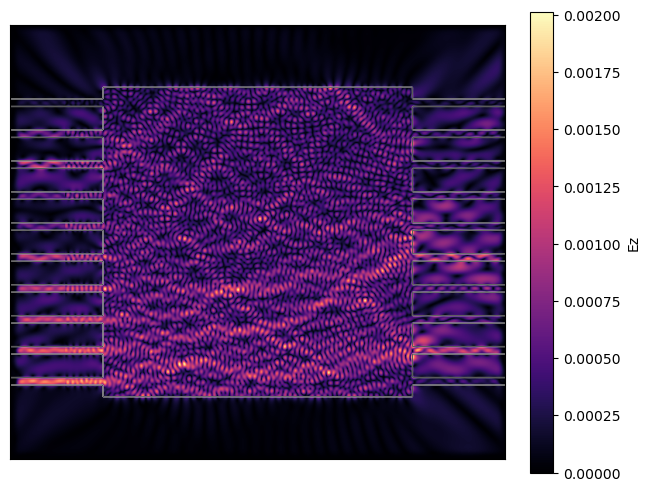

In [15]:
# set source and solve for electromagnetic fields
(Hx, Hy, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
# plt.xlim((nx - 2*l*L), (nx + 2*l*L))
# plt.ylim((ny - 2*l*H), (ny + 2*l*H))
plt.show()
# print(np.real(Ez))

Design region 

In [ ]:
simulation.init_design_region(design_region, eps_m, style='halfway')
simulation.plt_eps(outline=False)
plt.show()

In [ ]:
(Hx, Hy, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
# plt.xlim((nx - 2*l*L), (nx + 2*l*L))
# plt.ylim((ny - 2*l*H), (ny + 2*l*H))
plt.show()